[![View notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PyPartMC/blob/main/examples/particle_simulation_with_camp.ipynb)   
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyPartMC/blob/main/examples/particle_simulation_with_camp.ipynb)    
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyPartMC.git/main?urlpath=lab/tree/examples/particle_simulation_with_camp.ipynb)    
[![ARM JupyterHub](https://img.shields.io/static/v1?label=launch%20in&logo=jupyter&color=lightblue&message=ARM+JupyterHub)](https://jupyterhub.arm.gov/hub/user-redirect/git-pull?repo=https%3A//github.com/open-atmos/PyPartMC&branch=main&urlPath=) (requires [logging in with ARM account](https://www.arm.gov/capabilities/computing-resources) and directing Jupyter to a notebook within the cloned repo)

In [1]:
# This file is a part of PyPartMC licensed under the GNU General Public License v3
# Copyright (C) 2024 University of Illinois Urbana-Champaign
# Authors:
#  - https://github.com/compdyn/partmc/graphs/contributors
#  - https://github.com/open-atmos/PyPartMC/graphs/contributors

In [2]:
import sys
import os
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyPartMC')
elif 'JUPYTER_IMAGE' in os.environ and '.arm.gov' in os.environ['JUPYTER_IMAGE']:
    !pip --quiet install PyPartMC open_atmos_jupyter_utils
    _pypartmc_path = !pip show PyPartMC | fgrep Location | cut -f2 -d' '
    sys.path.extend(_pypartmc_path if _pypartmc_path[0] not in sys.path else [])

In [3]:
import json
import urllib
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from open_atmos_jupyter_utils import show_plot
import PyPartMC as ppmc
from PyPartMC import si

In [4]:
N_PART = 100

In [5]:
PATHS = [
    'cb05_abs_tol.json',
    'cb05_species.json',
    'custom_species.json',
    'aerosol_phases.json',
    'partitioning_species_params.json',
    'cb05_mechanism.noR142R143.json',
    'tsigaridis_2_product_SOA_scheme-mechanism.json',
    'tsigaridis_2_product_SOA_scheme-species.json',
]

In [7]:
CAMP_URL = (
    'https://raw.githubusercontent.com'
    '/open-atmos/camp/refs/heads/main/data/CAMP_v1_paper/modal/monarch_box_modal/'
)
for path in PATHS:
    print(path)
    with open(path, 'w', encoding='utf-8') as fout:
        with urllib.request.urlopen(CAMP_URL + path.replace('-', '/')) as fin:
            json.dump(
                json.loads(fin.read().decode('utf-8').replace('TO' + 'DO', 'TO-DO')),
                fout,
                indent=4
            )

cb05_abs_tol.json
cb05_species.json
custom_species.json
aerosol_phases.json
partitioning_species_params.json
cb05_mechanism.noR142R143.json
tsigaridis_2_product_SOA_scheme-mechanism.json
tsigaridis_2_product_SOA_scheme-species.json


In [8]:
with open('config.json', 'w', encoding='utf-8') as f:
    json.dump({
        "camp-files" : [
            "aerosol_representation.json",
            *PATHS
        ]
    }, f, indent=4)

In [9]:
with open('aerosol_representation.json', 'w', encoding='utf-8') as f:
    json.dump(
        {
            "camp-data" : [
            {
              "name" : "PartMC single particle",
              "type" : "AERO_REP_SINGLE_PARTICLE",
              "maximum computational particles" : N_PART * 2
            }
          ]
        }, f, indent=4
    )

In [30]:
T_INITIAL = 0.0
RUN_PART_ARGS = {}
RUN_PART_ARGS['env_state'] = ppmc.EnvState({
    "rel_humidity": 0.,
    "latitude": 0,
    "longitude": 0,
    "altitude": 0 * si.m,
    "start_time": 21600 * si.s,
    "start_day": 200,
})

In [31]:
RUN_PART_ARGS['camp_core'] = ppmc.CampCore("config.json")
RUN_PART_ARGS['photolysis'] = ppmc.Photolysis(RUN_PART_ARGS['camp_core'])

In [32]:
RUN_PART_ARGS['gas_data'] = ppmc.GasData(RUN_PART_ARGS['camp_core'])
RUN_PART_ARGS['aero_data'] = ppmc.AeroData(RUN_PART_ARGS['camp_core'])

In [33]:
RUN_PART_ARGS['gas_state'] = ppmc.GasState(RUN_PART_ARGS['gas_data'])
RUN_PART_ARGS['gas_state'].mix_rats = (
    {"NO": [0.1]},
    {"NO2": [1.]},
    {"O3": [5.0e1]},
    {"H2O2": [1.1]},
    {"CO": [2.1e2]},
    {"SO2": [0.8]},
    {"NH3": [0.5]},
    {"HCL": [0.7]},
    {"CH4": [2.2e3]},
    {"ETHA": [1.]},
    {"FORM": [1.2]},
    {"MEOH": [1.2e-1]},
    {"MEPX": [0.5]},
    {"ALD2": [1.]},
    {"PAR": [2.]},
    {"ETH": [0.2]},
    {"OLE": [2.3e-2]},
    {"IOLE": [3.1e-4]},
    {"TOL": [0.1]},
    {"XYL": [0.1]},
    {"NTR": [0.1]},
    {"PAN": [0.8]},
    {"AACD": [0.2]},
    {"ROOH": [2.5e-2]},
    {"ISOP": [5.]},
    {"O2": [2.095e8]},
    {"N2": [7.8e8]},
    {"H2": [5.6e2]},
    {"M": [1e9]}
)

In [34]:
TIME_TIMESERIES = [0, 86400]
RUN_PART_ARGS['scenario'] = ppmc.Scenario(
    RUN_PART_ARGS['gas_data'],
    RUN_PART_ARGS['aero_data'],
    {
        "temp_profile": [{"time": TIME_TIMESERIES}, {"temp": [290.016, 290.016]}],
        "pressure_profile": [
            {"time": TIME_TIMESERIES},
            {"pressure": [1e5, 1e5]},
        ],
        "height_profile": [{"time": TIME_TIMESERIES}, {"height": [1., 1.]}],
        "gas_emissions": [
            {"time": [0, 43200]},
            {"rate": [1., 0.]},
            {"SO2": [1.06E-9, 1.06E-9]},
            {"NO2": [7.56E-12, 7.56E-12]},
            {"NO": [1.44E-10, 1.44E-10]},
            {"CO": [1.96E-9, 1.96E-9]},
            {"ALD2": [4.25E-12, 4.25E-12]},
            {"FORM": [1.02E-11, 1.02E-11]},
            {"ETH": [4.62E-11, 4.62E-11]},
            {"IOLE": [1.49E-11, 1.49E-11]},
            {"OLE": [1.49E-11, 1.49E-11]},
            {"TOL": [1.53E-11, 1.53E-11]},
            {"XYL": [1.40E-11, 1.40E-11]},
            {"PAR": [4.27E-10, 4.27E-10]},
            {"ISOP": [6.03E-12, 6.03E-12]},
            {"MEOH": [5.92E-13, 5.92E-13]},
        ],
        "gas_background": [
            {"time": [0 * si.s]},
            {"rate": [0 / si.s]},
            {"NO": [0.1]},
            {"NO2": [1.]},
            {"O3": [5.0E+01]},
            {"H2O2": [1.1]},
            {"CO": [2.1E+02]},
            {"SO2": [0.8]},
            {"NH3": [0.5]},
            {"HCL": [0.7]},
            {"CH4": [2.2E+03]},
            {"ETHA": [1.]},
            {"FORM": [1.2]},
            {"MEOH": [1.2E-1]},
            {"MEPX": [0.5]},
            {"ALD2": [1.]},
            {"PAR": [2.]},
            {"ETH": [0.2]},
            {"OLE": [2.3E-2]},
            {"IOLE": [3.1E-4]},
            {"TOL": [0.1]},
            {"XYL": [0.1]},
            {"NTR": [0.1]},
            {"PAN": [0.8]},
            {"AACD": [0.2]},
            {"ROOH": [2.5E-2]},
            {"ISOP": [5.]},
            {"O2": [2.095E+08]},
            {"N2": [7.8E+08]},
            {"H2": [5.6E+02]},
            {"M": [1.0E+09]}
        ],
        "aero_emissions": [
            {"time": [0 * si.s]},
            {"rate": [0 / si.s]},
            {"dist": [[{
                "gasoline": {
                    "mass_frac": [{"organic_matter.POA": [1]}],
                    "diam_type": "geometric",
                    "mode_type": "log_normal",
                    "num_conc": 0.0 / si.m**3,
                    "geom_mean_diam": 5e-8 * si.m,
                    "log10_geom_std_dev": 0.24,
                },
            }]]},
        ],
        "aero_background": [
            {"time": [0 * si.s]},
            {"rate": [0 / si.s]},
            {"dist": [[{
                "back_small": {
                    "mass_frac": [{"organic_matter.POA": [1]}],
                    "diam_type": "geometric",
                    "mode_type": "log_normal",
                    "num_conc": 0 / si.m**3,
                    "geom_mean_diam": 0.02 * si.um,
                    "log10_geom_std_dev": 0.161,
                },
            }]]},
        ],
        "loss_function": "none",
    },
)

In [35]:
RUN_PART_ARGS['scenario'].init_env_state(RUN_PART_ARGS['env_state'], T_INITIAL)

In [36]:
AERO_DIST_INIT = ppmc.AeroDist(RUN_PART_ARGS['aero_data'], [
        {
            "init_small": {
                "mass_frac": [{"organic_matter.POA": [1]}],
                "diam_type": "geometric",
                "mode_type": "log_normal",
                "num_conc": 3.2e9 / si.m**3,
                "geom_mean_diam": 2.0e-8 * si.m,
                "log10_geom_std_dev": 0.161,
            },
            "init_large": {
                "mass_frac": [{"organic_matter.POA": [1]}],
                "diam_type": "geometric",
                "mode_type": "log_normal",
                "num_conc": 2.9e9 / si.m**3,
                "geom_mean_diam": 1.16e-7 * si.m,
                "log10_geom_std_dev": 0.217,
            },
            "init_coarse": {
                "mass_frac": [{"organic_matter.POA": [1]}],
                "diam_type": "geometric",
                "mode_type": "log_normal",
                "num_conc": 0.3e6 / si.m**3,
                "geom_mean_diam": 1.8e-6 * si.m,
                "log10_geom_std_dev": 0.38021124171160603,
            }
        }
    ]
)

In [37]:
RUN_PART_ARGS['run_part_opt'] = ppmc.RunPartOpt({
    "output_prefix": "urban_plume",
    "do_coagulation": False,
    "t_max": 86400 * si.s,
    "del_t": 6 * si.s,
    "do_camp_chem": True,
})

RUN_PART_ARGS['aero_state'] = ppmc.AeroState(
    RUN_PART_ARGS['aero_data'],
    N_PART,
    'nummass_source',
    RUN_PART_ARGS['camp_core']
)

RUN_PART_ARGS['aero_state'].dist_sample(
    AERO_DIST_INIT,
    sample_prop=1.0,
    create_time=0.0,
    allow_doubling=True,
    allow_halving=True,
)

51

In [38]:
DIAM_GRID = ppmc.BinGrid(30, "log", 1e-9, 1e-5)

In [39]:
OUTPUT = defaultdict(list)
last = defaultdict(float)
i_output = 1
for i_time in range(
    0,
    int(RUN_PART_ARGS['run_part_opt'].t_max / RUN_PART_ARGS['run_part_opt'].del_t) + 1
):
    if i_time != 0:
        (last["output_time"], last["progress_time"], i_output) = ppmc.run_part_timestep(
            *[RUN_PART_ARGS[key] for key in (
                'scenario', 'env_state', 'aero_data',
                'aero_state', 'gas_data', 'gas_state',
                'run_part_opt', 'camp_core', 'photolysis'
            )],
            i_time, T_INITIAL, last["output_time"], last["progress_time"], i_output,
        )
    for obj, keys in (
        (RUN_PART_ARGS['aero_state'], ('total_num_conc', 'total_mass_conc')),
        (RUN_PART_ARGS['gas_state'], ('mix_rats',)),
        (RUN_PART_ARGS['env_state'], ('elapsed_time', 'height', 'temp', 'rh')),
    ):
        for key in keys:
            OUTPUT[key].append(getattr(obj, key))
    if np.mod(i_time * RUN_PART_ARGS['run_part_opt'].del_t, 3600.0) == 0:
        OUTPUT['dists'].append(ppmc.histogram_1d(
            DIAM_GRID,
            RUN_PART_ARGS['aero_state'].dry_diameters,
            RUN_PART_ARGS['aero_state'].num_concs
        ))
for key in OUTPUT:
    OUTPUT[key] = np.asarray(OUTPUT[key])

In [40]:
plt.rcParams.update({'font.size': 9})
plt.rcParams.update({'figure.figsize': (3.08, 2.5)})
plt.rcParams.update({"axes.grid" : True})

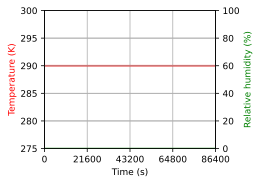

In [41]:
plt.plot(OUTPUT['elapsed_time'], OUTPUT['temp'], 'r')
plt.ylabel('Temperature (K)', color='r')
plt.ylim([275, 300])
plt.xticks(np.linspace(0, OUTPUT['elapsed_time'][-1], 5))
plt.xlim([OUTPUT['elapsed_time'][i] for i in (0, -1)])
plt.xlabel('Time (s)')
plt.twinx()
plt.plot(OUTPUT['elapsed_time'], OUTPUT['rh'] * 100, 'g')
plt.ylabel('Relative humidity (%)', color='g')
plt.ylim([0, 100])
show_plot()

In [42]:
def set_tickmarks(axes, n_yticks):
    ylims = axes.get_ylim()
    if np.log10(ylims[0]) > 1:
        val = -int(np.ceil(np.abs(np.log10(ylims[0])))) + 1
    else:
        val = int(np.ceil(np.abs(np.log10(ylims[0])))) + 1     
    ymin = round(ylims[0] - .1 * ylims[0], val)
    ymax = round(ylims[1] + .1 * ylims[1], val)
    plt.ylim([ymin, ymax])
    plt.yticks(np.linspace(ymin, ymax, n_yticks))

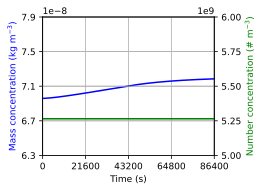

In [43]:
plt.plot(OUTPUT['elapsed_time'], OUTPUT['total_mass_conc'], "b", label="mass conc")
plt.ylabel("Mass concentration (kg m$^{-3}$)", color='b')
plt.xlabel("Time (s)")
n_ticks = 5
set_tickmarks(plt.gca(), n_ticks)
plt.twinx()
plt.plot(OUTPUT['elapsed_time'], OUTPUT['total_num_conc'], "g", label="num conc")
plt.xticks(np.linspace(0, OUTPUT['elapsed_time'][-1], n_ticks))
plt.xlim([OUTPUT['elapsed_time'][i] for i in (0, -1)])
set_tickmarks(plt.gca(), n_ticks)
plt.ylabel(r"Number concentration ($\#$ m$^{-3}$)", color='g')
show_plot()

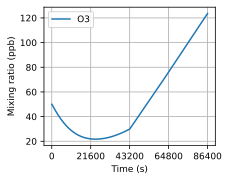

In [44]:
for i_spec, spec in enumerate(["O3"]):
    i_spec = RUN_PART_ARGS['gas_data'].spec_by_name(spec)
    l, = plt.plot(
        OUTPUT['elapsed_time'],
        OUTPUT['mix_rats'][:, i_spec],
        label=spec
    )
plt.xlabel("Time (s)")
plt.ylabel("Mixing ratio (ppb)")
plt.xticks(np.linspace(0, OUTPUT['elapsed_time'][-1], 5))
plt.legend()
show_plot()

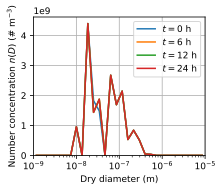

In [45]:
for hour in (0, 6, 12, 24):
    plt.plot(DIAM_GRID.centers, OUTPUT['dists'][hour], label=f'$t = {hour}$ h')
plt.xscale("log")
plt.xlabel("Dry diameter (m)")
plt.ylabel(r"Number concentration $n(D)$ ($\#$ m$^{-3}$)")
plt.ylim(bottom=0)
plt.legend()
plt.xlim([DIAM_GRID.edges[i] for i in (0, -1)])
show_plot()